Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Experiment 1: fixed detector in many scenarios

This notebook computes the performance of the fixed strategies in various scenarios. This experiment is described in Sec. 5.2 of CVPR submission "Learning Intelligent Dialogs for Bounding Box Annotation".

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division
from __future__ import print_function
import math
import gym
from gym import spaces

import pandas as pd

import tensorflow as tf

from IPython import display
import time

from third_party import np_box_ops
import annotator, detector, dialog, environment

To specify the experiments, 3 paramters need to be defined: 

*   detector
*   type of drawing
*   desired quality of bounding boxes (only the strong detector can be used in this notebook).

All together, it gives 8 possible experiment, 6 of which were presented in the paper.

In [0]:
# desired quality: high (min_iou=0.7) and low (min_iou=0.5)
min_iou = 0.7 # @param ["0.5", "0.7"]
# drawing speed: high (time_draw=7) and low (time_draw=25)
time_draw = 7 # @param ["7", "25"]

# if detector is weak, then we use best MIL, if it is strong, we use detector trained on PASCAL 2012
detector_weak = False # @param ['False']


Other parameters of the experiment

In [0]:
random_seed = 805 # global variable that fixes the random seed everywhere for replroducibility of results

# what kind of features will be used to represent the state
# numerical values 1-20 correspond to one hot encoding of class
predictive_fields = ['prediction_score', 'relative_size', 'avg_score', 'dif_avg_score', 'dif_max_score', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

time_verify = 1.8 # @param

# select one of the 10 folds
fold = 8 # @param

# Load all data

In [0]:
# Download GT:
# wget wget https://storage.googleapis.com/iad_pascal_annotations_and_detections/pascal_gt_for_iad.h5
# Download detections with features
# wget https://storage.googleapis.com/iad_pascal_annotations_and_detections/pascal_proposals_plus_features_for_iad.h5

download_dir = ''
ground_truth = pd.read_hdf(download_dir + 'pascal_gt_for_iad.h5', 'ground_truth')
box_proposal_features = pd.read_hdf(download_dir + 'pascal_proposals_plus_features_for_iad.h5', 'box_proposal_features')

In [6]:
ground_truth.sample(n=3)

,image_id,class_id,xmax,xmin,ymax,ymin,height,width
12687,voc07det/008106.jpg,16,306,287,259,231,500,375
5361,voc07det/003420.jpg,7,467,393,261,229,375,500
8993,voc07det/005755.jpg,18,401,79,237,26,400,500


In [7]:
box_proposal_features.sample(n=3)

,image_id,class_id,prediction_score,avg_score,max_score,max_class_score,dif_max_score,relative_size,dif_avg_score,xmin,...,11,12,13,14,15,16,17,18,19,20
9180718,voc07det/009756.jpg,5,5.768422e-06,0.016292,0.999980,0.000037,0.000032,0.002784,-0.016286,393,...,0,0,0,0,0,0,0,0,0,0
1568379,voc07det/003051.jpg,14,1.521613e-07,0.010089,0.999921,0.000324,0.000324,0.002625,-0.010089,69,...,0,0,0,1,0,0,0,0,0,0
9663466,voc07det/009205.jpg,15,3.133233e-07,0.005994,0.999876,0.002042,0.002042,0.001760,-0.005993,394,...,0,0,0,0,1,0,0,0,0,0


# Code for ML Ninja: Replay Buffer

The ReplayBuffer class is used for storing transitions of interaction with the environment. Each transition consists of:
- state - The state that the environment gave the agent.
- action - The action taken by the agent.
- reward - The reward given for taking the action from the state.
- next_state - The state resulting from the action.
- terminal - A flag indicating whether the environment terminated with this transition.

The ReplayBuffer class provides a random samples of transitions in a Minibatch.

In [0]:
class Minibatch:
  
  def __init__(self, state, action, reward, next_state, terminal):
    self.state = state
    self.action = action
    self.reward = reward
    self.next_state = next_state
    self.terminal = terminal
    
  def __str__(self):
    return str(zip(self.state, self.action, self.reward, self.next_state, self.terminal))
  
  def __getitem__(self, x):
    return self.state[x], self.action[x], self.reward[x], self.next_state[x], self.terminal[x]

class ReplayBuffer:
  
  def __init__(self, buffer_size=1e4):
    self.buffer_size = int(buffer_size)
    self.n = 0
    self.write_index = 0
    
  # Initialize numpy arrays to the full maximum size of the ReplayBuffer
  def _init_nparray(self, state, action, reward, next_state, terminal):
    
    # For each column, initialize the column for entire buffer_size.
    self.all_states = np.array([state] * self.buffer_size)
    self.all_actions = np.array([action] * self.buffer_size)
    self.all_rewards = np.array([reward] * self.buffer_size)
    self.all_next_states = np.array([next_state] * self.buffer_size)
    self.all_terminals = np.array([terminal] * self.buffer_size)
    
    self.n = 1
    self.write_index = 1
  
  def store_transition(self, state, action, reward, next_state, terminal):
    
    # If buffer arrays not yet initialized, initialize them
    if self.n == 0:
      self._init_nparray(state, action, reward, next_state, terminal)
      return
    
    self.all_states[self.write_index] = state
    self.all_actions[self.write_index] = action
    self.all_rewards[self.write_index] = reward
    self.all_next_states[self.write_index] = next_state
    self.all_terminals[self.write_index] = terminal
    
    self.write_index += 1
    if self.write_index >= self.buffer_size:
      self.write_index = 0
    
    # Keep track of the max index to be used for sampling.
    if self.n < self.buffer_size:
      self.n += 1
  
  def sample_minibatch(self, batch_size=32):
    minibatch_indices = np.random.permutation(self.n)[:batch_size]
    
    minibatch = Minibatch(
      self.all_states[minibatch_indices],
      self.all_actions[minibatch_indices],
      self.all_rewards[minibatch_indices],
      self.all_next_states[minibatch_indices],
      self.all_terminals[minibatch_indices],
    )
    
    return minibatch

# Code for ML Ninja: DQN Class

The following code block implements Deepmind's DQN algorithm:
https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

The algorithm uses Q-learning to train an estimator Q(s,a), for actions and states in the environment.

In [0]:
class DQN:
  
  def __init__(self,
               observation_space,
               action_space,
               learning_rate=1e-3,
               batch_size=32,
               is_target_dqn=False,
               hidden_layer_sizes=[30, 30],
               discount_rate=0.99,
               target_copy_factor=0.001,
               session=None
              ):
    
    self.observation_space = observation_space
    self.action_space = action_space
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.is_target_dqn = is_target_dqn
    self.hidden_layer_sizes = hidden_layer_sizes
    self.discount_rate = discount_rate
    self.target_copy_factor = target_copy_factor
    self.session = session or tf.Session()
    
    self._initialized = False
    
    if not is_target_dqn:
      self._target_dqn = DQN(
          observation_space=observation_space,
          action_space=action_space,
          learning_rate=learning_rate,
          batch_size=batch_size,
          hidden_layer_sizes=hidden_layer_sizes,
          is_target_dqn=True,
          session=self.session,
      )
    
    # Make the net for inference and training. Requires that target DQN made first.
    self._make_net()
  
  def _make_net(self):
    
    observation_length = sum([len(observ) for observ in self.observation_space.sample()])
    var_scope_name = "dqn" if not self.is_target_dqn else "target_dqn"
    with tf.variable_scope(var_scope_name):
      
      # Placeholder for states, first dimension for batch size, second for observation vector length.
      self._state_placeholder = tf.placeholder(dtype=tf.float32, shape=(self.batch_size, observation_length))

      # Make first hidden layer
      self._layers = []
      self._layers.append(tf.contrib.layers.fully_connected(
          inputs = self._state_placeholder,
          num_outputs = self.hidden_layer_sizes[0],
          trainable = not self.is_target_dqn,
          variables_collections = [var_scope_name],
          scope = "layer0"
      ))

      # Make subsequent hidden layers.
      for i in xrange(1, len(self.hidden_layer_sizes)):
        self._layers.append(tf.contrib.layers.fully_connected(
            inputs = self._layers[-1],
            num_outputs = self.hidden_layer_sizes[i],
          trainable = not self.is_target_dqn,
          variables_collections = [var_scope_name],
          scope = "layer{}".format(i)
        ))

      # Make action-value predictions layer.
      self._av_predictions = tf.contrib.layers.linear(
          inputs = self._layers[-1],
          num_outputs = self.action_space.n,
          trainable = not self.is_target_dqn,
          variables_collections = [var_scope_name],
          scope = "av_predictions"
      )

      # If not the target DQN, make the placeholders and ops for computing Bellman loss and training.
      if not self.is_target_dqn:
        self._action_placeholder = tf.placeholder(dtype=tf.int32, shape=(self.batch_size))
        self._reward_placeholder = tf.placeholder(dtype=tf.float32, shape=(self.batch_size))
        self._terminal_placeholder = tf.placeholder(dtype=tf.bool, shape=(self.batch_size))

        ones = tf.ones(shape=(self.batch_size))
        zeros = tf.zeros(shape=(self.batch_size))

        # Contains 1 where not terminal, 0 where terminal. (batch_size x 1)
        terminal_mask = tf.where(self._terminal_placeholder, zeros, ones)

        # Contains 1 where action was taken. (batch_size x action_space.n)
        action_taken_mask = tf.one_hot(
            indices = self._action_placeholder,
            depth = self.action_space.n,
            on_value = 1.0,
            off_value = 0.0,
            dtype = tf.float32
        )

        # Contains 1 where action was not taken. (batch_size x action_space.n)
        action_not_taken_mask = tf.one_hot(
            indices = self._action_placeholder,
            depth = self.action_space.n,
            on_value = 0.0,
            off_value = 1.0,
            dtype = tf.float32
        )

        # For samples that are not terminal, contains max next step action value predictions. (batch_size x 1)
        masked_target_av_predictions = tf.reduce_max(self._target_dqn._av_predictions, reduction_indices=[1]) * terminal_mask

        # Target values for actions taken. (batch_size x 1)
        #   = r + discount_rate * Q_target(s', a')  , for non-terminal transitions
        #   = r                                     , for terminal transitions
        actions_taken_targets = self._reward_placeholder + self.discount_rate * masked_target_av_predictions
        actions_taken_targets = tf.reshape(actions_taken_targets, (self.batch_size, 1))

        # Target values for all actions. (batch_size x action_space.n)
        #   = the target predicted av, for indices corresponding to actions taken
        #   = the current predicted av, for indices corresponding to actions not taken
        all_action_targets = actions_taken_targets * action_taken_mask + self._av_predictions * action_not_taken_mask
        self._all_action_targets = all_action_targets

        # Define error, loss
        error = all_action_targets - self._av_predictions
        self._loss = tf.reduce_sum(tf.square(error))

        # Define train op
        opt = tf.train.AdamOptimizer(self.learning_rate)
        self._opt = opt
        self._train_op = opt.minimize(self._loss, var_list=tf.get_collection('dqn'))

        # Construct ops to copy over weighted average of parameter values to target net
        copy_factor = self.target_copy_factor
        copy_factor_complement = 1 - copy_factor
        self._copy_ops = [target_var.assign(copy_factor * my_var + copy_factor_complement * target_var)
                          for (my_var, target_var)
                          in zip(tf.get_collection('dqn'), tf.get_collection('target_dqn'))]
    
  def _copy_to_target_dqn(self):
    assert not self.is_target_dqn, "cannot call _copy_to_target_dqn on target DQN"    
    
    self.session.run(self._copy_ops)
    
  def _check_initialized(self):
    
    if self._initialized:
      return
    
    self.session.run(tf.initialize_all_variables())      
    self._initialized = True
    
  def get_action(self, state):
    
    self._check_initialized()

    state_batch = (state,) * self.batch_size
    av_predictions = self.session.run(
        self._av_predictions,
        feed_dict = { self._state_placeholder : state_batch }
    )

    # av_predictions currently holds a whole minibatch. Extract first row.
    av_predictions = av_predictions[0]

    # Choose the index of max action.
    max_action = 0
    max_action_value = -float("inf")
    for i in xrange(self.action_space.n):
      if av_predictions[i] > max_action_value:
        max_action = i
        max_action_value = av_predictions[max_action]

    return max_action
        
  def save_params(self):
    params = {}
    for var in tf.get_collection('dqn'):
      params[var.name] = self.session.run(var)
    return params
      
  def load_params(self, params):
    for var in tf.get_collection('dqn'):
      self.session.run(var.assign(params[var.name]))
    
  def train(self, minibatch):
    
    assert not self.is_target_dqn, "cannot call train() on target DQN"
    self._check_initialized()
    
    # Run a step of optimization with the minibatch fields.
    loss, _ = self.session.run(
        [self._loss, self._train_op],
        feed_dict = {
            self._state_placeholder : minibatch.state,
            self._action_placeholder : minibatch.action,
            self._reward_placeholder : minibatch.reward,
            self._target_dqn._state_placeholder : minibatch.next_state,
            self._terminal_placeholder : minibatch.terminal,
        },
    )
    
    self._copy_to_target_dqn()
    
    return loss

# Initialise the experiment

In [0]:
the_annotator = annotator.AnnotatorSimple(ground_truth, random_seed, time_verify, time_draw, min_iou)
the_detector = detector.Detector(box_proposal_features, predictive_fields)

In [0]:
image_class = ground_truth[['image_id', 'class_id']]
image_class = image_class.drop_duplicates()

Select the training and testing data according to the selected fold. We split all images in 10 approximately equal parts and each fold includes these images together with all classes present in them.

In [0]:
# get a list of unique images
unique_image = image_class['image_id'].drop_duplicates()
# a list of image+class pairs
image_class_array = image_class.values[:,0]


if fold==1:
  index_image_class1 = 0
else:
  image_division1 = unique_image.iloc[502+501*(fold-2)]
  index_image_class1 = np.searchsorted(image_class_array, image_division1, side='right')
  
if fold==10:
  index_image_class2 = len(image_class_array)
else:
  image_division2 = unique_image.iloc[502+501*(fold-1)]
  index_image_class2 = np.searchsorted(image_class_array, image_division2, side='right')

# the selected fold becomes the training set
image_class_trainval = image_class.iloc[index_image_class1:index_image_class2]
# the other 9 folds become test set
image_class_test = pd.concat([image_class.iloc[0:index_image_class1],image_class.iloc[index_image_class2:]])

n_train = 500    # reserve samples for training
# permute data to get training and validation subsets
all_indeces_permuted = np.random.permutation(len(image_class_trainval))
indeces_for_train = all_indeces_permuted[0:n_train]
indeces_for_val = all_indeces_permuted[n_train:]
image_class_train = image_class_trainval.iloc[indeces_for_train]
image_class_val = image_class_trainval.iloc[indeces_for_val]

Initialise the environment for testing the strategies.

In [0]:
env_train = environment.AnnotatingDataset(the_annotator, the_detector, image_class_train)
env_val = environment.AnnotatingDataset(the_annotator, the_detector, image_class_val)
env_test = environment.AnnotatingDataset(the_annotator, the_detector, image_class_test)

# Experiment with RL

This class implements the environment simulating a user annotating images of PASCAL dataset, following the
  OpenAI Gym interface for RL environments.
  
- States are a combination of features of an image and a proposed box for annotation.
- Actions (0,1) correspond to (do box verification, do extreme clicking).
- Reward is -time per iteration.
- Reward is 0 when annotation is obtained.
- Episode terminates when annotation for an image is obtained

## Training RL agent

The following code block runs the training process on the AnnotatingPASCAL environment, using the DQN as an agent.

First, some initial episodes are taken, storing their results in the ReplayBuffer, this warm-starts the replay buffer with some experience, so that early stages of learning do not overfit.

Next, many training iterations are performed. Each training iteration has several phases:
- Run training episodes. Each transition observed is stored in the replay buffer. With epsilon probability, at each timestep, a random action is taken for exploration.
- Run several updates to the DQN neural network parameters, with minibatches of transitions from the ReplayBuffer.
- Run testing episodes. Every action is taken directly from the current agent. Store the returns from the environment.

Finally, an average of the test returns and nn train error are plotted over the iteration index.

Hyperparameter Explanation:
- batch_size: How many samples are pulled from the Replay Buffer for one SGD step on neural network parameters.
- learning_rate: Constant that adjusts how large a step SGD takes per iteration.
- hidden_layer_sizes: A list of sizes for hidden layers of the neural network.
- discount_rate: Per-timestep discounting of future reward values. A lower value means that short-term rewards will be prioritized.
- WARM_START_EPISODES: How many episodes of random experience to gather before training starts, so that the Replay Buffer has enough data.
- TRAINING_ITERATIONS: How many iterations of training/testing to do.
- TRAINING_EPISODES_PER_ITERATION: How many episodes to run before training.
- TEST_EPISODES_PER_ITERATION: How many episodes to run for averaging performance of the current Q-function approximation.
- NN_UPDATES_PER_ITERATION: How many SGD steps to take per iteration.

In [0]:
# Warm start episodes

tf.reset_default_graph()

# Initialize the DQN agent
agent = DQN(env_train.observation_space, env_train.action_space, 
            batch_size=80, # @param
           learning_rate=1e-3, # @param
           hidden_layer_sizes=[30, 30], # @param
           discount_rate=1,
           )
REPLAY_BUFFER_SIZE = 1e4 # @param
replay_buffer = ReplayBuffer(buffer_size=REPLAY_BUFFER_SIZE)

num_action_classes = env_train.action_space.n

# Warm-start the replay buffer with some random actions. 
WARM_START_EPISODES = 100 # @param
for _ in xrange(WARM_START_EPISODES):
  state = env_train.reset()
  terminal = False
  while not terminal:
    # Choose a random action
    action = np.random.randint(0, num_action_classes)
    next_state, reward, terminal, _ = env_train.step(action)
    # Store the transition in the replay buffer.
    replay_buffer.store_transition(state, action, reward, next_state, terminal)
    # Get ready for next step
    state = next_state

In [21]:
# Run training and validation episodes

# Run multiple training iterations. Each iteration consits of:
#   - training episodes (with exploration)
#   - neural network updates
#   - test episodes for evaluating performance

# Exploration rate
EPSILON = 0.2 # @param
# Can experiemnt with dynamically changing the eps: EPSILON -EPSILON*(iteration/TRAINING_ITERATIONS)

TRAINING_ITERATIONS = 500 # @param
# at each training ietration TRAINING_EPISODES_PER_ITERATION episodes are simulated
TRAINING_EPISODES_PER_ITERATION = 10 # @param
# at each training iteration NN_UPDATES_PER_ITERATION gradient steps are made
NN_UPDATES_PER_ITERATION = 30 # @param

train_episode_rewards = []
val_episode_rewards = []
agent_params = {}

best_iteration = 0
best_time = -float("inf")

# can set the number of samples to be used for estimating training error or validation error to be smaller for faster executions
n_for_trainerror = 200 #len(image_class_train)
n_for_valerror = 200 #len(image_class_val)

for iteration in xrange(TRAINING_ITERATIONS):
  
  # Simulate training episodes.
  for _ in xrange(TRAINING_EPISODES_PER_ITERATION):
    state = env_train.reset()
    terminal = False
    while not terminal:
      action = agent.get_action(state)
      # With epsilon probability, take a random action.
      if np.random.ranf() < EPSILON: 
        action = np.random.randint(0, num_action_classes)
      next_state, reward, terminal, _ = env_train.step(action)
      replay_buffer.store_transition(state, action, reward, next_state, terminal)
      state = next_state

  # Do neural network updates
  for _ in xrange(NN_UPDATES_PER_ITERATION):
    minibatch = replay_buffer.sample_minibatch(agent.batch_size)
    agent.train(minibatch)

  # Store the agent params from this iteration.
  agent_params[iteration] = agent.save_params()

  # Compute the training and validation error 20 times during the training iterations
  if (iteration+1) % (TRAINING_ITERATIONS / 20) == 0:

    print('Episode ', iteration, end = ': ')
    # Run episodes to evaluate train reward.
    train_reward = 0
    for i in xrange(n_for_trainerror):
      state = env_train.reset(current_index=i)
      terminal = False    
      while not terminal:
        action = agent.get_action(state)
        next_state, reward, terminal, _ = env_train.step(action)
        state = next_state
        train_reward += reward
    # Store the train episode stats.
    print('average trainign error = ', - train_reward/n_for_trainerror)
    train_episode_rewards.append(train_reward/n_for_trainerror)


    # Run episodes to evaluate validation reward.
    val_reward = 0
    for i in xrange(n_for_valerror):
      state = env_val.reset(current_index=i)
      terminal = False    
      while not terminal:
        action = agent.get_action(state)
        next_state, reward, terminal, _ = env_val.step(action)
        state = next_state
        val_reward += reward
    # Store the test episode stats.
    val_episode_rewards.append(val_reward/n_for_valerror)

    # remember the iteration with the lowest validation error for early stopping
    if val_reward/n_for_valerror>best_time:
      best_time = val_reward/n_for_valerror
      best_iteration = iteration

Episode  24: average trainign error =  10.049
Episode  49: average trainign error =  10.049
Episode  74: average trainign error =  10.049
Episode  99: average trainign error =  10.049
Episode  124: average trainign error =  10.049
Episode  149: average trainign error =  4.827
Episode  174: average trainign error =  3.342
Episode  199: average trainign error =  3.222
Episode  224: average trainign error =  3.239
Episode  249: average trainign error =  3.213
Episode  274: average trainign error =  3.23
Episode  299: average trainign error =  3.23
Episode  324: average trainign error =  3.23
Episode  349: average trainign error =  3.256
Episode  374: average trainign error =  3.256
Episode  399: average trainign error =  3.256
Episode  424: average trainign error =  3.23
Episode  449: average trainign error =  3.238
Episode  474: average trainign error =  3.23
Episode  499: average trainign error =  3.23


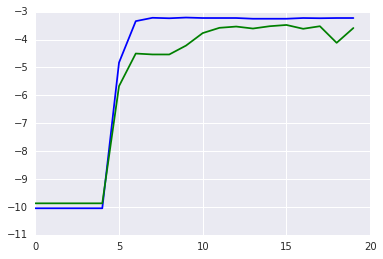

In [22]:
# plot the training and validation errors

plt.plot(train_episode_rewards, 'b', label = 'train reward')
plt.plot(val_episode_rewards, 'g', label = 'validation reward')

## Test the learnt agent

In [23]:
%output_height 300

# load the agent from the iteration with the lowest validation error
print('Best iteration = ', best_iteration)
print('Best validation time = ', best_time)
agent.load_params(agent_params[best_iteration]) 

test_reward = 0
for i in xrange(len(image_class_test)):
  state = env_test.reset(current_index=i)
  terminal = False

  print('Episode ', i, end = ': ')
  while not terminal:
    # Take an environment step
    action = agent.get_action(state)
    if action==0:
      print('V', end='')
    elif action==1:
      print('D', end='')
    next_state, reward, terminal, _ = env_test.step(action)
    state = next_state
    test_reward += reward
  print()

print('Total duration of all episodes = ', -test_reward)
print('Average episode duration = ', -test_reward/len(image_class_test))

Best iteration =  399
Best validation time =  -3.479
Episode  0: VV
Episode  1: V
Episode  2: V
Episode  3: V
Episode  4: V
Episode  5: V
Episode  6: V
Episode  7: V
Episode  8: V
Episode  9: V
Episode  10: VD
Episode  11: V
Episode  12: V
Episode  13: V
Episode  14: V
Episode  15: V
Episode  16: V
Episode  17: V
Episode  18: VVV
Episode  19: V
Episode  20: V
Episode  21: V
Episode  22: D
Episode  23: V
Episode  24: V
Episode  25: V
Episode  26: V
Episode  27: V
Episode  28: V
Episode  29: V
Episode  30: V
Episode  31: V
Episode  32: V
Episode  33: D
Episode  34: V
Episode  35: VD
Episode  36: V
Episode  37: D
Episode  38: V
Episode  39: V
Episode  40: D
Episode  41: VVVVD
Episode  42: VV
Episode  43: V
Episode  44: V
Episode  45: V
Episode  46: V
Episode  47: V
Episode  48: V
Episode  49: V
Episode  50: D
Episode  51: V
Episode  52: D
Episode  53: VVV
Episode  54: V
Episode  55: V
Episode  56: VVV
Episode  57: V
Episode  58: V
Episode  59: VD
Episode  60: V
Episode  61: V
Episode  62:

Episode  576: V
Episode  577: V
Episode  578: V
Episode  579: V
Episode  580: V
Episode  581: VD
Episode  582: V
Episode  583: V
Episode  584: VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVD
Episode  585: VV
Episode  586: V
Episode  587: V
Episode  588: V
Episode  589: V
Episode  590: V
Episode  591: V
Episode  592: V
Episode  593: VVVVD
Episode  594: D
Episode  595: V
Episode  596: VVVD
Episode  597: V
Episode  598: D
Episode  599: V
Episode  600: V
Episode  601: V
Episode  602: V
Episode  603: V
Episode  604: V
Episode  605: V
Episode  606: V
Episode  607: V
Episode  608: VV
Episode  609: V
Episode  610: V
Episode  611: V
Episode  612: D
Episode  613: V
Episode  614: VD
Episode  615: V
Episode  616: V
Episode  617: V
Episode  618: V
Episode  619: V
Episode  620: V
Episode  621: V
Episode  622: V
Episode  623: V
Episode  624: V
Episode  625: V
Episode  626: V
Episode  627: V
Episode  628: V
Episode  629: V
Episode  630: V
Episode  631: V
Episode  632: V
Episode  633: V
Episode  634: V
Episode

Episode  1145: V
Episode  1146: D
Episode  1147: D
Episode  1148: VD
Episode  1149: V
Episode  1150: VD
Episode  1151: VVVVVVVVVVVVVVVVVVVVVVVVVVD
Episode  1152: V
Episode  1153: V
Episode  1154: V
Episode  1155: V
Episode  1156: V
Episode  1157: V
Episode  1158: V
Episode  1159: V
Episode  1160: D
Episode  1161: V
Episode  1162: V
Episode  1163: V
Episode  1164: V
Episode  1165: V
Episode  1166: V
Episode  1167: V
Episode  1168: V
Episode  1169: V
Episode  1170: V
Episode  1171: VV
Episode  1172: D
Episode  1173: V
Episode  1174: D
Episode  1175: V
Episode  1176: V
Episode  1177: V
Episode  1178: V
Episode  1179: V
Episode  1180: VVV
Episode  1181: V
Episode  1182: V
Episode  1183: V
Episode  1184: D
Episode  1185: VVV
Episode  1186: V
Episode  1187: V
Episode  1188: V
Episode  1189: D
Episode  1190: D
Episode  1191: V
Episode  1192: V
Episode  1193: V
Episode  1194: V
Episode  1195: VD
Episode  1196: D
Episode  1197: V
Episode  1198: VVD
Episode  1199: V
Episode  1200: V
Episode  120

Episode  1696: VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVD
Episode  1697: V
Episode  1698: VD
Episode  1699: V
Episode  1700: VD
Episode  1701: V
Episode  1702: V
Episode  1703: V
Episode  1704: V
Episode  1705: V
Episode  1706: V
Episode  1707: V
Episode  1708: V
Episode  1709: V
Episode  1710: V
Episode  1711: V
Episode  1712: VVVD
Episode  1713: VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVD
Episode  1714: V
Episode  1715: D
Episode  1716: V
Episode  1717: V
Episode  1718: VV
Episode  1719: V
Episode  1720: D
Episode  1721: V
Episode  1722: V
Episode  1723: V
Episode  1724: V
Episode  1725: V
Episode  1726: V
Episode  1727: V
Episode  1728: D
Episode  1729: V
Episode  1730: V
Episode  1731: V
Episode  1732: V
Episode  1733: V
Episode  1734: V
Episode  1735: VD
Episode  1736: V
Episode  1737: D
Episode  1738: V
Episode  1739: V
Episode  1740: V
Episode  1741: V
Episode  1742: V
Episode  1743: V
Episode  1744: VV
Episode  1745: V
Episode  1746: V
Episode  174

Episode  2271: VVVVD
Episode  2272: V
Episode  2273: V
Episode  2274: V
Episode  2275: V
Episode  2276: V
Episode  2277: D
Episode  2278: V
Episode  2279: V
Episode  2280: V
Episode  2281: V
Episode  2282: V
Episode  2283: VV
Episode  2284: V
Episode  2285: V
Episode  2286: V
Episode  2287: V
Episode  2288: V
Episode  2289: V
Episode  2290: V
Episode  2291: V
Episode  2292: V
Episode  2293: V
Episode  2294: V
Episode  2295: VVVVVVVVVD
Episode  2296: VV
Episode  2297: V
Episode  2298: V
Episode  2299: VV
Episode  2300: V
Episode  2301: V
Episode  2302: V
Episode  2303: V
Episode  2304: VVVVVV
Episode  2305: VD
Episode  2306: V
Episode  2307: V
Episode  2308: V
Episode  2309: V
Episode  2310: VD
Episode  2311: V
Episode  2312: V
Episode  2313: V
Episode  2314: D
Episode  2315: VD
Episode  2316: V
Episode  2317: V
Episode  2318: V
Episode  2319: V
Episode  2320: D
Episode  2321: V
Episode  2322: V
Episode  2323: V
Episode  2324: V
Episode  2325: V
Episode  2326: D
Episode  2327: D
Episode

Episode  2775: VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVD
Episode  2776: V
Episode  2777: VD
Episode  2778: VVD
Episode  2779: V
Episode  2780: V
Episode  2781: D
Episode  2782: VV
Episode  2783: D
Episode  2784: VD
Episode  2785: VVVV
Episode  2786: D
Episode  2787: D
Episode  2788: V
Episode  2789: VD
Episode  2790: D
Episode  2791: V
Episode  2792: D
Episode  2793: V
Episode  2794: V
Episode  2795: V
Episode  2796: V
Episode  2797: V
Episode  2798: V
Episode  2799: V
Episode  2800: V
Episode  2801: V
Episode  2802: VVV
Episode  2803: VVVVVVVVVVVVVVVVVVVVVVVVVD
Episode  2804: V
Episode  2805: V
Episode  2806: VV
Episode  2807: V
Episode  2808: V
Episode  2809: V
Episode  2810: V
Episode  2811: V
Episode  2812: V
Episode  2813: V
Episode  2814: D
Episode  2815: V
Episode  2816: VVVD
Episode  2817: VV
Episode  2818: D
Episode  2819: V
Episode  2820: V
Episode  2821: V
Episode  2822: VD
Episode  2823: V
Episode  2824: V
Episode  2825: VD
Episode  2826: V
Episode  2827: V
Episode  2828: V
Epi

Episode  3283: VD
Episode  3284: VD
Episode  3285: VD
Episode  3286: V
Episode  3287: V
Episode  3288: V
Episode  3289: D
Episode  3290: V
Episode  3291: D
Episode  3292: V
Episode  3293: VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVD
Episode  3294: V
Episode  3295: V
Episode  3296: V
Episode  3297: V
Episode  3298: V
Episode  3299: V
Episode  3300: V
Episode  3301: V
Episode  3302: V
Episode  3303: V
Episode  3304: V
Episode  3305: V
Episode  3306: VVVVVVVVVVVVVVVVVVVVVVVVVD
Episode  3307: V
Episode  3308: V
Episode  3309: V
Episode  3310: VVD
Episode  3311: VV
Episode  3312: V
Episode  3313: VD
Episode  3314: V
Episode  3315: VD
Episode  3316: D
Episode  3317: D
Episode  3318: V
Episode  3319: VVVVD
Episode  3320: V
Episode  3321: D
Episode  3322: V
Episode  3323: V
Episode  3324: V
Episode  3325: V
Episode  3326: V
Episode  3327: V
Episode  3328: D
Episode  3329: V
Episode  3330: V
Episode  3331: VVVD
Episode  3332: V
Episode  3333: V
Episode  3334: V
Episode  33

Episode  3818: VVVD
Episode  3819: D
Episode  3820: V
Episode  3821: V
Episode  3822: VV
Episode  3823: V
Episode  3824: V
Episode  3825: V
Episode  3826: V
Episode  3827: V
Episode  3828: V
Episode  3829: V
Episode  3830: V
Episode  3831: V
Episode  3832: V
Episode  3833: V
Episode  3834: V
Episode  3835: VD
Episode  3836: V
Episode  3837: V
Episode  3838: V
Episode  3839: V
Episode  3840: V
Episode  3841: V
Episode  3842: VV
Episode  3843: V
Episode  3844: V
Episode  3845: D
Episode  3846: V
Episode  3847: V
Episode  3848: V
Episode  3849: V
Episode  3850: V
Episode  3851: V
Episode  3852: D
Episode  3853: V
Episode  3854: V
Episode  3855: V
Episode  3856: V
Episode  3857: V
Episode  3858: VV
Episode  3859: VVVD
Episode  3860: V
Episode  3861: V
Episode  3862: VD
Episode  3863: V
Episode  3864: V
Episode  3865: V
Episode  3866: VVD
Episode  3867: V
Episode  3868: V
Episode  3869: V
Episode  3870: V
Episode  3871: V
Episode  3872: V
Episode  3873: V
Episode  3874: V
Episode  3875: V
E

Episode  4349: V
Episode  4350: D
Episode  4351: V
Episode  4352: V
Episode  4353: V
Episode  4354: V
Episode  4355: VVVVVVVVVVVVVVVVVVVVVVVVVVVD
Episode  4356: V
Episode  4357: V
Episode  4358: D
Episode  4359: V
Episode  4360: V
Episode  4361: V
Episode  4362: VD
Episode  4363: V
Episode  4364: V
Episode  4365: V
Episode  4366: VVD
Episode  4367: V
Episode  4368: D
Episode  4369: D
Episode  4370: V
Episode  4371: D
Episode  4372: V
Episode  4373: V
Episode  4374: V
Episode  4375: VD
Episode  4376: VV
Episode  4377: V
Episode  4378: V
Episode  4379: V
Episode  4380: V
Episode  4381: V
Episode  4382: VD
Episode  4383: V
Episode  4384: V
Episode  4385: V
Episode  4386: V
Episode  4387: VVVVVVVVVVVD
Episode  4388: V
Episode  4389: D
Episode  4390: VVV
Episode  4391: D
Episode  4392: V
Episode  4393: V
Episode  4394: VD
Episode  4395: V
Episode  4396: VV
Episode  4397: VVD
Episode  4398: V
Episode  4399: VVV
Episode  4400: VD
Episode  4401: V
Episode  4402: VD
Episode  4403: V
Episode  44

Episode  4897: V
Episode  4898: D
Episode  4899: V
Episode  4900: VD
Episode  4901: V
Episode  4902: V
Episode  4903: V
Episode  4904: VD
Episode  4905: V
Episode  4906: V
Episode  4907: V
Episode  4908: D
Episode  4909: V
Episode  4910: V
Episode  4911: VD
Episode  4912: V
Episode  4913: VD
Episode  4914: V
Episode  4915: V
Episode  4916: V
Episode  4917: V
Episode  4918: VVD
Episode  4919: V
Episode  4920: V
Episode  4921: VVD
Episode  4922: V
Episode  4923: V
Episode  4924: D
Episode  4925: V
Episode  4926: V
Episode  4927: V
Episode  4928: VV
Episode  4929: V
Episode  4930: V
Episode  4931: V
Episode  4932: VVVV
Episode  4933: VVD
Episode  4934: VVVD
Episode  4935: VVD
Episode  4936: VVD
Episode  4937: V
Episode  4938: VD
Episode  4939: V
Episode  4940: V
Episode  4941: V
Episode  4942: V
Episode  4943: V
Episode  4944: V
Episode  4945: D
Episode  4946: V
Episode  4947: V
Episode  4948: V
Episode  4949: V
Episode  4950: D
Episode  4951: V
Episode  4952: V
Episode  4953: VD
Episode 

Episode  5461: VVD
Episode  5462: V
Episode  5463: V
Episode  5464: V
Episode  5465: V
Episode  5466: V
Episode  5467: V
Episode  5468: V
Episode  5469: V
Episode  5470: V
Episode  5471: V
Episode  5472: V
Episode  5473: V
Episode  5474: VD
Episode  5475: V
Episode  5476: V
Episode  5477: V
Episode  5478: V
Episode  5479: V
Episode  5480: V
Episode  5481: D
Episode  5482: V
Episode  5483: V
Episode  5484: V
Episode  5485: V
Episode  5486: V
Episode  5487: V
Episode  5488: V
Episode  5489: V
Episode  5490: V
Episode  5491: V
Episode  5492: VD
Episode  5493: V
Episode  5494: V
Episode  5495: V
Episode  5496: V
Episode  5497: V
Episode  5498: V
Episode  5499: VVVVV
Episode  5500: V
Episode  5501: D
Episode  5502: V
Episode  5503: V
Episode  5504: VVD
Episode  5505: V
Episode  5506: V
Episode  5507: V
Episode  5508: D
Episode  5509: VVD
Episode  5510: VV
Episode  5511: VV
Episode  5512: V
Episode  5513: D
Episode  5514: VD
Episode  5515: V
Episode  5516: V
Episode  5517: V
Episode  5518: V

Episode  6021: V
Episode  6022: D
Episode  6023: V
Episode  6024: V
Episode  6025: V
Episode  6026: V
Episode  6027: VVD
Episode  6028: V
Episode  6029: V
Episode  6030: VV
Episode  6031: VV
Episode  6032: V
Episode  6033: V
Episode  6034: VVVVVVVVVVVVVVVVVVVVVVVVVVVVVD
Episode  6035: V
Episode  6036: D
Episode  6037: VD
Episode  6038: V
Episode  6039: VV
Episode  6040: V
Episode  6041: V
Episode  6042: V
Episode  6043: VD
Episode  6044: V
Episode  6045: D
Episode  6046: V
Episode  6047: V
Episode  6048: V
Episode  6049: V
Episode  6050: VD
Episode  6051: D
Episode  6052: V
Episode  6053: V
Episode  6054: V
Episode  6055: V
Episode  6056: VD
Episode  6057: V
Episode  6058: V
Episode  6059: V
Episode  6060: VVD
Episode  6061: VD
Episode  6062: V
Episode  6063: V
Episode  6064: V
Episode  6065: V
Episode  6066: V
Episode  6067: D
Episode  6068: V
Episode  6069: V
Episode  6070: VV
Episode  6071: V
Episode  6072: V
Episode  6073: V
Episode  6074: V
Episode  6075: V
Episode  6076: V
Episod

Episode  6607: VVVVD
Episode  6608: V
Episode  6609: VVVVVVVVVVVVD
Episode  6610: V
Episode  6611: V
Episode  6612: V
Episode  6613: VD
Episode  6614: VD
Episode  6615: V
Episode  6616: V
Episode  6617: V
Episode  6618: V
Episode  6619: V
Episode  6620: VD
Episode  6621: V
Episode  6622: VD
Episode  6623: VD
Episode  6624: VVVD
Episode  6625: D
Episode  6626: V
Episode  6627: VVD
Episode  6628: V
Episode  6629: VVD
Episode  6630: V
Episode  6631: V
Episode  6632: VV
Episode  6633: V
Episode  6634: V
Episode  6635: V
Episode  6636: V
Episode  6637: D
Episode  6638: D
Episode  6639: V
Episode  6640: V
Episode  6641: V
Episode  6642: V
Episode  6643: V
Episode  6644: V
Episode  6645: V
Episode  6646: V
Episode  6647: VD
Episode  6648: D
Episode  6649: D
Episode  6650: V
Episode  6651: V
Episode  6652: V
Episode  6653: V
Episode  6654: V
Episode  6655: VV
Episode  6656: V
Episode  6657: VVD
Episode  6658: VD
Episode  6659: V
Episode  6660: V
Episode  6661: V
Episode  6662: V
Episode  6663: